In [1]:
! pip install -q condacolab
import condacolab
condacolab.install()
!mamba install -c conda-forge rdkit
! pip install chembl-webresource-client

✨🍰✨ Everything looks OK!

                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        Supported by @QuantStack

        GitHub:  https://github.com/QuantStack/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████

Getting  conda-forge linux-64
Getting  conda-forge noarch
Getting  pkgs/main linux-64
Getting  pkgs/ma

In [2]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

from rdkit import Chem, DataStructs
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools, Descriptors, Draw, MACCSkeys, rdFingerprintGenerator
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [3]:
molecule_dataset = pd.read_csv('/content/active_filtered.csv',
    usecols=["molecule_chembl_id", "smiles", "pIC50"],
)
print(f"Number of molecules in dataset: {len(molecule_dataset)}")
molecule_dataset.head(5)

Number of molecules in dataset: 129


,molecule_chembl_id,smiles,pIC50
0,CHEMBL567,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,9.522879
1,CHEMBL3885419,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,8.958607
2,CHEMBL8514,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,8.958607
3,CHEMBL267930,O=C(CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1,8.896196
4,CHEMBL493,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,8.800794


### Let's consider all connections falling within the interquantile range of distances of positive examples from the centroid as suitable

So, now we need to find centroid for all '+'

In [4]:
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

In [5]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [6]:
compounds = []
for _, chembl_id, smiles in molecule_dataset[["molecule_chembl_id", "smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), chembl_id))
compounds[:5]

# Create fingerprints for all molecules
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)
fingerprints = [rdkit_gen.GetFingerprint(mol) for mol, idx in compounds]

In [7]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.9)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  1
# clusters with only 1 compound:  0
# clusters with >5 compounds:  1
# clusters with >25 compounds:  1
# clusters with >100 compounds:  1


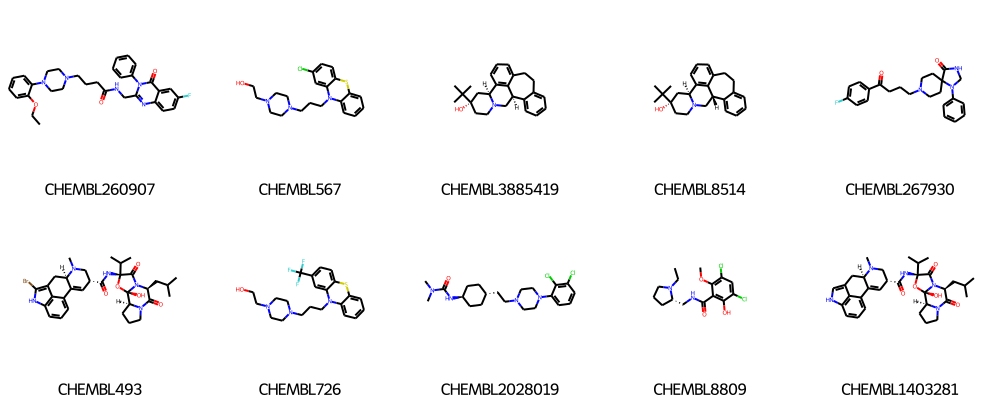

In [8]:
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i][0] for i in clusters[0][:10]],
    legends=[compounds[i][1] for i in clusters[0][:10]],
    molsPerRow=5,
)

In [ ]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters][0]

In [ ]:
cluster_centers

(<rdkit.Chem.rdchem.Mol at 0x7fcd819cab20>, 'CHEMBL260907')

In [ ]:
PandasTools.AddMoleculeColumnToFrame(molecule_dataset, "smiles")
circular_fp_list = rdFingerprintGenerator.GetCountFPs(molecule_dataset["ROMol"].tolist())
maccs_fp_list = molecule_dataset["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()
molecule_dataset['circular_fp'] = circular_fp_list
molecule_dataset['maccs_fp'] = maccs_fp_list

In [ ]:
molecule_dataset[molecule_dataset.molecule_chembl_id ==cluster_centers[1]]['smiles']

128    CCOc1ccccc1N1CCN(CCCC(=O)NCc2nc3ccc(F)cc3c(=O)...
Name: smiles, dtype: object

In [ ]:
query = Chem.MolFromSmiles(molecule_dataset.loc[128,'smiles'])

In [ ]:
maccs_fp_query = MACCSkeys.GenMACCSKeys(query)
circular_fp_query = rdFingerprintGenerator.GetCountFPs([query])[0]

In [ ]:
from numpy.ma.core import negative
molecule_dataset["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
molecule_dataset["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [ ]:
molecule_dataset["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
molecule_dataset["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [ ]:
molecule_dataset[["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]]

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,0.594595,0.317568,0.745763,0.482051
1,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,0.467532,0.176829,0.637168,0.300518
2,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,0.467532,0.176829,0.637168,0.300518
3,O=C(CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1,0.753425,0.388889,0.859375,0.560000
4,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,0.608696,0.186869,0.756757,0.314894
...,...,...,...,...,...
124,COc1cccc(-c2csc(CCN3CCN(c4ccccc4OC)CC3)n2)c1.Cl,0.589744,0.374150,0.741935,0.544554
125,COc1ccc2c(c1)C[C@H]1c3cc(O)c(OC)cc3CCN1C2,0.513889,0.181818,0.678899,0.307692
126,CCN1CCC[C@H]1CNC(=O)c1c(OC)ccc(Br)c1OC,0.636364,0.164474,0.777778,0.282486
127,CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@...,0.652778,0.229885,0.789916,0.373832


In [ ]:
down_q = np.quantile(molecule_dataset['tanimoto_morgan'], 0.25)
down_q 

0.22784810126582278

In [ ]:
up_q = np.quantile(molecule_dataset['tanimoto_morgan'], 0.75)
up_q

0.3269230769230769

## Dealing with negatives

In [ ]:
random_molecules = pd.read_csv('/content/all_compounds_after_tt_3.csv',
    usecols=["molecule_chembl_id", "smiles"],
)

In [ ]:
random_molecules.shape

(181054, 2)

In [ ]:
random_molecule_sample = random_molecules.sample(5000)
random_molecule_sample.shape
random_molecule_sample.reset_index(drop=True, inplace=True)
random_molecule_sample.head(10)

,molecule_chembl_id,smiles
0,CHEMBL1382592,O=C(CSCC(=O)NCc1ccco1)NCc1ccco1
1,CHEMBL4090043,Nc1ncc(-c2n[nH]c(C3(c4ccccc4)CC3)n2)nc1-n1nnc2...
2,CHEMBL2386920,CCc1ccc(C)n2c(=O)cc(Cn3cnc4ccccc43)nc12
3,CHEMBL3676032,COc1ncc(F)cc1[C@H]1CCCN1c1ccn2ncc(C(=O)Nc3ccc(...
4,CHEMBL3503365,Cc1noc(C)c1CN1CCO[C@@H]2[C@@H]1CC[C@H]2Oc1nccc...
5,CHEMBL1608862,COCc1cc(C)nc(Nc2ccc(C)c(C)c2)c1C#N
6,CHEMBL3553736,COC[C@@H]1CCC[C@@]12CN(Cc1ccc(C)s1)CCO2
7,CHEMBL3448432,Cc1ccc(CN2CCc3nc(C(C)C)nc(O)c3CC2)s1
8,CHEMBL4248597,O=S(=O)(c1cccc2ncccc12)N1CCC[C@@H]1CCN1CCN(c2c...
9,CHEMBL4113935,C[C@H](c1ccc2ccccc2c1)N(C(=O)[C@H]1CNCCO1)C1CC1


In [ ]:
add_neg = pd.read_csv('/content/unactive_filtered.csv')
add_neg.head()

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL2057451,COc1cc2c(cc1OC)[C@@H]1Cc3cc(C)cc(C)c3CN1CC2,5.937305,0.0
1,CHEMBL81,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,5.930332,0.0
2,CHEMBL84158,CCN(CC)CCNC(=O)c1cc(S(C)(=O)=O)ccc1OC,5.909389,0.0
3,CHEMBL3903297,c1c2c(cc3c1OCO3)CN1CCc3cc4c(cc3[C@@H]1C2)OCO4,5.906789,0.0
4,CHEMBL1934130,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...,5.823909,0.0


In [ ]:
neg = pd.concat([add_neg, random_molecule_sample])
neg

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL2057451,COc1cc2c(cc1OC)[C@@H]1Cc3cc(C)cc(C)c3CN1CC2,5.937305,0.0
1,CHEMBL81,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,5.930332,0.0
2,CHEMBL84158,CCN(CC)CCNC(=O)c1cc(S(C)(=O)=O)ccc1OC,5.909389,0.0
3,CHEMBL3903297,c1c2c(cc3c1OCO3)CN1CCc3cc4c(cc3[C@@H]1C2)OCO4,5.906789,0.0
4,CHEMBL1934130,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...,5.823909,0.0
...,...,...,...,...
4995,CHEMBL3959587,Cc1c(-c2ccc(C(F)(F)F)cc2)nnc(N2CCN(c3cnc(C(C)(...,NaN,NaN
4996,CHEMBL1521401,Cn1c(SCc2nc3ccccc3[nH]2)nnc1-c1cccnc1,NaN,NaN
4997,CHEMBL4115585,CCOc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H]...,NaN,NaN
4998,CHEMBL2396958,O=S(=O)(c1cccc(C(F)(F)F)c1)N1[C@@H]2Cc3n[nH]cc...,NaN,NaN


In [ ]:
PandasTools.AddMoleculeColumnToFrame(neg, "smiles")
circular_fp_list = rdFingerprintGenerator.GetCountFPs(neg["ROMol"].tolist())
maccs_fp_list = neg["ROMol"].apply(MACCSkeys.GenMACCSKeys).tolist()
neg['circular_fp'] = circular_fp_list
neg['maccs_fp'] = maccs_fp_list

In [ ]:
neg["tanimoto_maccs"] = DataStructs.BulkTanimotoSimilarity(
    maccs_fp_query, maccs_fp_list
)
neg["tanimoto_morgan"] = DataStructs.BulkTanimotoSimilarity(
    circular_fp_query, circular_fp_list
)

In [ ]:
neg["dice_maccs"] = DataStructs.BulkDiceSimilarity(maccs_fp_query, maccs_fp_list)
neg["dice_morgan"] = DataStructs.BulkDiceSimilarity(
    circular_fp_query, circular_fp_list
)

In [ ]:
neg[["smiles", "tanimoto_maccs", "tanimoto_morgan", "dice_maccs", "dice_morgan"]]

,smiles,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
0,COc1cc2c(cc1OC)[C@@H]1Cc3cc(C)cc(C)c3CN1CC2,0.486486,0.150000,0.654545,0.260870
1,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,0.565789,0.264706,0.722689,0.418605
2,CCN(CC)CCNC(=O)c1cc(S(C)(=O)=O)ccc1OC,0.477778,0.151316,0.646617,0.262857
3,c1c2c(cc3c1OCO3)CN1CCc3cc4c(cc3[C@@H]1C2)OCO4,0.453333,0.125749,0.623853,0.223404
4,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...,0.571429,0.299401,0.727273,0.460829
...,...,...,...,...,...
4995,Cc1c(-c2ccc(C(F)(F)F)cc2)nnc(N2CCN(c3cnc(C(C)(...,0.543210,0.177778,0.704000,0.301887
4996,Cn1c(SCc2nc3ccccc3[nH]2)nnc1-c1cccnc1,0.407407,0.202614,0.578947,0.336957
4997,CCOc1ccc(Cc2cc([C@@H]3O[C@H](CO)[C@@H](O)[C@H]...,0.385542,0.173410,0.556522,0.295567
4998,O=S(=O)(c1cccc(C(F)(F)F)c1)N1[C@@H]2Cc3n[nH]cc...,0.347826,0.211180,0.516129,0.348718


In [ ]:
index_to_keep = neg.index[(neg['tanimoto_morgan'] >= down_q) & (neg['tanimoto_morgan'] <= up_q)].tolist()
len(index_to_keep)

1401

,molecule_chembl_id,smiles,pIC50,active,ROMol,circular_fp,maccs_fp,tanimoto_maccs,tanimoto_morgan,dice_maccs,dice_morgan
1,CHEMBL81,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,5.930332,0.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.565789,0.264706,0.722689,0.418605
1,CHEMBL4090043,Nc1ncc(-c2n[nH]c(C3(c4ccccc4)CC3)n2)nc1-n1nnc2...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.395062,0.251534,0.566372,0.401961
4,CHEMBL1934130,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...,5.823909,0.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.571429,0.299401,0.727273,0.460829
4,CHEMBL3503365,Cc1noc(C)c1CN1CCO[C@@H]2[C@@H]1CC[C@H]2Oc1nccc...,NaN,NaN,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.658824,0.153439,0.794326,0.266055
7,CHEMBL584554,CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...,5.798603,0.0,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",<rdkit.DataStructs.cDataStructs.UIntSparseIntV...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.569620,0.238095,0.725806,0.384615

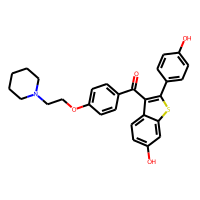
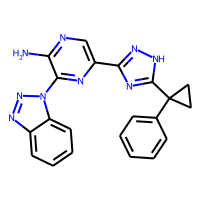
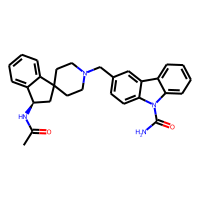
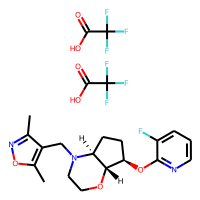
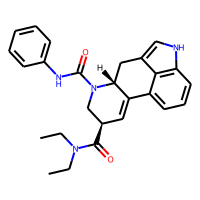

In [ ]:
random_to_keep = neg.loc[index_to_keep]
random_to_keep.head()

In [ ]:
random_to_keep[['molecule_chembl_id', 'smiles']].to_csv('negative_final.csv', index=False)

## Featurizer

In [ ]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.AllChem import GetMorganFingerprintAsBitVect

In [ ]:
active = pd.read_csv('/content/active_filtered.csv').drop('pIC50', axis=1)
active

,molecule_chembl_id,smiles,active
0,CHEMBL567,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,1.0
1,CHEMBL3885419,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,1.0
2,CHEMBL8514,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,1.0
3,CHEMBL267930,O=C(CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1,1.0
4,CHEMBL493,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,1.0
...,...,...,...
124,CHEMBL2373205,COc1cccc(-c2csc(CCN3CCN(c4ccccc4OC)CC3)n2)c1.Cl,1.0
125,CHEMBL2057453,COc1ccc2c(c1)C[C@H]1c3cc(O)c(OC)cc3CCN1C2,1.0
126,CHEMBL22242,CCN1CCC[C@H]1CNC(=O)c1c(OC)ccc(Br)c1OC,1.0
127,CHEMBL250689,CC(=O)c1cccc(NC(=O)N[C@@H]2CCCC[C@H]2CN2CCC[C@...,1.0


In [ ]:
negative = pd.read_csv('/content/negative_final.csv')
negative

,molecule_chembl_id,smiles
0,CHEMBL81,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...
1,CHEMBL4090043,Nc1ncc(-c2n[nH]c(C3(c4ccccc4)CC3)n2)nc1-n1nnc2...
2,CHEMBL1934130,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...
3,CHEMBL3503365,Cc1noc(C)c1CN1CCO[C@@H]2[C@@H]1CC[C@H]2Oc1nccc...
4,CHEMBL584554,CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...
...,...,...
1421,CHEMBL2407783,CC(=O)c1ccccc1-c1cc2c(-c3cnn(C4CCN(C(C)=O)CC4)...
1422,CHEMBL4160169,CC(Oc1ccnc(Nc2cnn(C)c2)c1)c1cccc(C(=O)NCc2cc(F...
1423,CHEMBL1590841,CC(C)c1ccc(S(=O)(=O)c2cnc(SCC(=O)Nc3ccc(F)cc3F...
1424,CHEMBL1476385,COc1ccc(OC)c(NC(=O)c2cnc(N3CCCCC3)c3ccccc23)c1


In [ ]:
negative['active'] = 0
negative

,molecule_chembl_id,smiles,active
0,CHEMBL81,O=C(c1ccc(OCCN2CCCCC2)cc1)c1c(-c2ccc(O)cc2)sc2...,0
1,CHEMBL4090043,Nc1ncc(-c2n[nH]c(C3(c4ccccc4)CC3)n2)nc1-n1nnc2...,0
2,CHEMBL1934130,CC(=O)N[C@@H]1CC2(CCN(Cc3ccc4c(c3)c3ccccc3n4C(...,0
3,CHEMBL3503365,Cc1noc(C)c1CN1CCO[C@@H]2[C@@H]1CC[C@H]2Oc1nccc...,0
4,CHEMBL584554,CCN(CC)C(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34)C[C@H...,0
...,...,...,...
1421,CHEMBL2407783,CC(=O)c1ccccc1-c1cc2c(-c3cnn(C4CCN(C(C)=O)CC4)...,0
1422,CHEMBL4160169,CC(Oc1ccnc(Nc2cnn(C)c2)c1)c1cccc(C(=O)NCc2cc(F...,0
1423,CHEMBL1590841,CC(C)c1ccc(S(=O)(=O)c2cnc(SCC(=O)Nc3ccc(F)cc3F...,0
1424,CHEMBL1476385,COc1ccc(OC)c(NC(=O)c2cnc(N3CCCCC3)c3ccccc23)c1,0


In [ ]:
dataset = pd.concat([active, negative])
dataset

,molecule_chembl_id,smiles,active
0,CHEMBL567,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,1.0
1,CHEMBL3885419,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,1.0
2,CHEMBL8514,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,1.0
3,CHEMBL267930,O=C(CCCN1CCC2(CC1)C(=O)NCN2c1ccccc1)c1ccc(F)cc1,1.0
4,CHEMBL493,CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...,1.0
...,...,...,...
1421,CHEMBL2407783,CC(=O)c1ccccc1-c1cc2c(-c3cnn(C4CCN(C(C)=O)CC4)...,0.0
1422,CHEMBL4160169,CC(Oc1ccnc(Nc2cnn(C)c2)c1)c1cccc(C(=O)NCc2cc(F...,0.0
1423,CHEMBL1590841,CC(C)c1ccc(S(=O)(=O)c2cnc(SCC(=O)Nc3ccc(F)cc3F...,0.0
1424,CHEMBL1476385,COc1ccc(OC)c(NC(=O)c2cnc(N3CCCCC3)c3ccccc23)c1,0.0


## We have class inbalance:
## 1426 0 - negative
## 129 1 - positive

In [ ]:
dataset.to_csv('final_data.csv', index=False)

In [ ]:
dataset = pd.read_csv('final_data.csv')

In [ ]:
import matplotlib.pyplot as plt

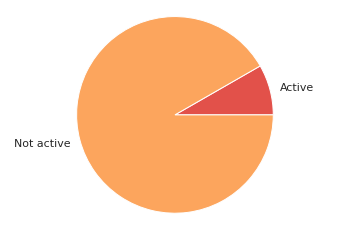

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_palette("Spectral")
labels = 'Active', "Not active"
sizes = [sum(dataset['active']),(len(dataset['active']) - sum(dataset['active']))]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels)
ax.axis('equal') 
plt.show()

In [ ]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        return np.array(GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits))
    if method == "morgan3":
        return np.array(GetMorganFingerprintAsBitVect(mol, 3, nBits=n_bits))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [ ]:
compound_df = dataset.copy()

In [ ]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

,molecule_chembl_id,smiles,active,fp
0,CHEMBL567,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3885419,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL8514,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Helper functions

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

In [ ]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)
o for ROC AUC
    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

In [ ]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set (stratified split)
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, stratify=label_to_model, random_state=7)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]

print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1244
Test data size: 311


In [ ]:
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [ ]:
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.62
Specificity: 0.99
AUC: 0.94


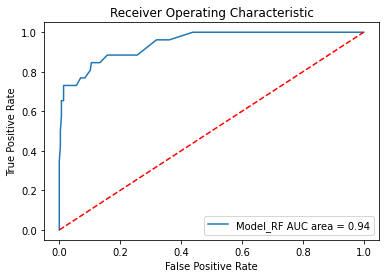

In [ ]:
models = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [ ]:
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.58
Specificity: 0.99
AUC: 0.95


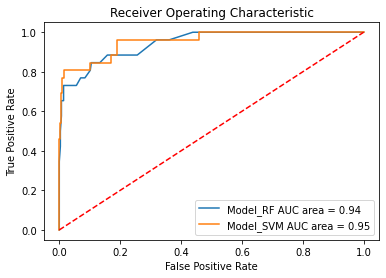

In [ ]:
models.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y);

In [ ]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=7)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.54
Specificity: 0.99
AUC: 0.93


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


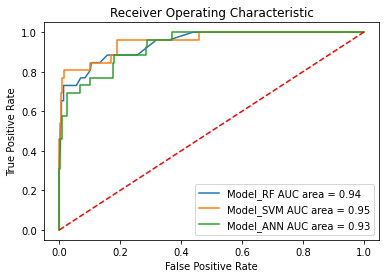

In [ ]:
# Append ANN model
models.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(models, static_test_x, static_test_y, True);

## CV

In [ ]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=7)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

In [ ]:
N_FOLDS = 5

In [ ]:
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.96 	and std : 0.01 
Mean sensitivity: 0.58 	and std : 0.05 
Mean specificity: 0.99 	and std : 0.01 
Mean AUC: 0.96 	and std : 0.01 
Time taken : 1.34s


Model_SVM
Mean accuracy: 0.95 	and std : 0.01 
Mean sensitivity: 0.50 	and std : 0.06 
Mean specificity: 0.99 	and std : 0.01 
Mean AUC: 0.95 	and std : 0.04 
Time taken : 2.92s


Model_ANN


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Mean accuracy: 0.94 	and std : 0.01 
Mean sensitivity: 0.47 	and std : 0.13 
Mean specificity: 0.98 	and std : 0.01 
Mean AUC: 0.93 	and std : 0.03 
Time taken : 5.35s



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


## Let's compare with cross-validation performance for molecules encoded using Morgan fingerprint and not MACCS keys.

In [ ]:
# Reset data frame
compound_df = dataset.copy()

In [ ]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,active,fp
0,CHEMBL567,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(Cl)cc32)CC1,1.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3885419,CC(C)(C)[C@]1(O)CCN2C[C@@H]3c4ccccc4CCc4cccc(c...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL8514,CC(C)(C)[C@]1(O)CCN2C[C@H]3c4ccccc4CCc4cccc(c4...,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
for model in models:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        pass
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.96 	and std : 0.01 
Mean sensitivity: 0.58 	and std : 0.09 
Mean specificity: 1.00 	and std : 0.00 
Mean AUC: 0.97 	and std : 0.02 
Time taken : 3.25s


Model_SVM
Mean accuracy: 0.93 	and std : 0.01 
Mean sensitivity: 0.16 	and std : 0.04 
Mean specificity: 1.00 	and std : 0.00 
Mean AUC: 0.97 	and std : 0.02 
Time taken : 65.67s


Model_ANN


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Mean accuracy: 0.95 	and std : 0.01 
Mean sensitivity: 0.85 	and std : 0.07 
Mean specificity: 0.96 	and std : 0.01 
Mean AUC: 0.93 	and std : 0.04 
Time taken : 34.21s



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


### The best result is for ANN with morgan fingerprints (in terms of sensitivity)

### or for RF with morgan fingerprints (in terms of ROC AUC)

ANN model -  MLPClassifier (Multi-layer Perceptron classifier) with 3 layers, each with 5 neurons (http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

## Let's try to tune these 2 models

In [ ]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, stratify=label_to_model, random_state=7)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'activation': ['relu', 'logistic', 'identity', 'tanh'],
          'hidden_layer_sizes': [(100,), (50,100,), (50,75,100,)],
          'learning_rate' : ['constant', 'adaptive', 'invscaling']
         }

mlp_classif_grid = GridSearchCV(MLPClassifier(random_state=123), param_grid=params, n_jobs=-1, cv=5, verbose=5, scoring='roc_auc')
mlp_classif_grid.fit(X_train,y_train)

print('Best Parameters : ',mlp_classif_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters :  {'activation': 'logistic', 'hidden_layer_sizes': (50, 100), 'learning_rate': 'constant'}


In [ ]:
optimal_mlp = mlp_classif_grid.best_estimator_

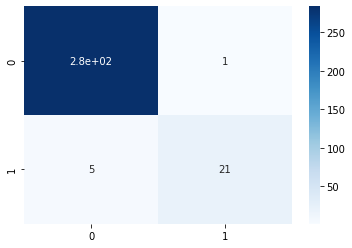

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = optimal_mlp.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues")

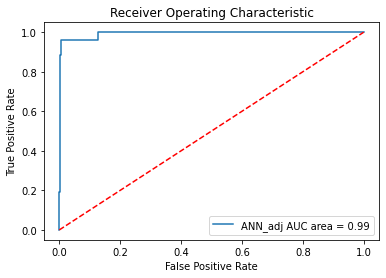

In [ ]:
models = [{"label": "ANN_adj", "model": optimal_mlp}]
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test);

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       0.95      0.81      0.88        26

    accuracy                           0.98       311
   macro avg       0.97      0.90      0.93       311
weighted avg       0.98      0.98      0.98       311



In [ ]:
import pickle
filename = 'finalized_ANN.sav'
pickle.dump(model, open(filename, 'wb'))

In [ ]:
random_grid = {'bootstrap': [True, False],
 'max_depth': [20, 50, 100],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 500, 1000, 1200]}

In [ ]:
rf = RandomForestClassifier(random_state=123)
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid, n_jobs=-1, cv=5, verbose=5, scoring='roc_auc')
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [20, 50, 100],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 500, 1000, 1200]},
             scoring='roc_auc', verbose=5)

In [ ]:
optimal_rf = rf_random.best_estimator_
optimal_rf

RandomForestClassifier(max_depth=20, n_estimators=1000, random_state=123)

In [ ]:
print('Best Parameters : ',rf_random.best_params_)

Best Parameters :  {'bootstrap': True, 'max_depth': 20, 'max_features': 'auto', 'n_estimators': 1000}


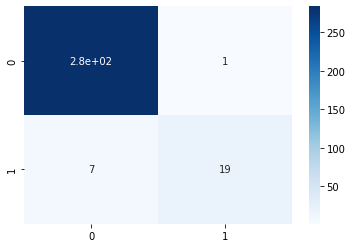

In [ ]:
predictions = optimal_rf.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues")

In [ ]:
print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       285
           1       0.95      0.73      0.83        26

    accuracy                           0.97       311
   macro avg       0.96      0.86      0.91       311
weighted avg       0.97      0.97      0.97       311



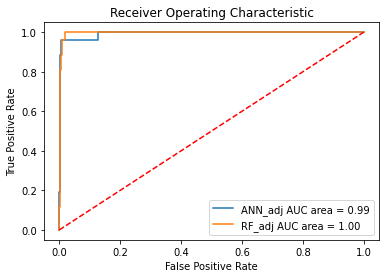

In [ ]:
models.append({"label": "RF_adj", "model": optimal_rf})
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test);

In [ ]:
filename = 'finalized_RF.sav'
pickle.dump(optimal_rf, open(filename, 'wb'))

## Some additional scores taking into account the class imbalance

In [ ]:
from sklearn.metrics import f1_score, balanced_accuracy_score

In [ ]:
test_y_pred = optimal_mlp.predict(X_test)
f1_score(y_test, test_y_pred, average='micro')

0.9807073954983923

In [ ]:
balanced_accuracy_score(y_test, test_y_pred)

0.9020917678812416

In [ ]:
test_y_pred = optimal_rf.predict(X_test)
f1_score(y_test, test_y_pred, average='micro')

0.9742765273311897

In [ ]:
balanced_accuracy_score(y_test, test_y_pred)

0.8636302294197031

## Now let's try more complex featurization

In [ ]:
!pip install deepchem
import deepchem as dc

In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-gzz8_v76
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-gzz8_v76
     |████████████████████████████████| 24.1 MB 75 kB/s 
     |████████████████████████████████| 793 kB 40.4 MB/s 
     |████████████████████████████████| 292 kB 55.2 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 1.6 MB 42.1 MB/s 
     |████████████████████████████████| 381 kB 61.5 MB/s 
     |████████████████████████████████| 106 kB 49.1 MB/s 
     |████████████████████████████████| 1.1 MB 34.8 MB/s 
     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 100 kB 9.4 MB/s 
  Created wheel for mol2vec: filename=mol2vec-0.1-py3-none-any.whl size=14025 sha256=cac718c58880cd318181c75f617913e9d744441d4e4942ae6b39c7297c590b66
  Sto

### Mol2VecFingerprint 

In [ ]:
df = dataset.copy()

In [ ]:
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
from gensim.models import word2vec

In [ ]:
PandasTools.AddMoleculeColumnToFrame(df, smilesCol="smiles")

In [ ]:
model = word2vec.Word2Vec.load('model_300dim.pkl')

In [ ]:
df['sentence'] = df.apply(lambda x: MolSentence(mol2alt_sentence(x['ROMol'], 1)), axis=1)
df['mol2vec'] = [DfVec(x) for x in sentences2vec(df['sentence'], model, unseen='UNK')]

In [ ]:
X = np.array([x.vec for x in df['mol2vec']])
y = np.array(df['active'].astype(int))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=7)

In [ ]:
params = {'activation': ['relu', 'logistic', 'identity', 'tanh'],
          'hidden_layer_sizes': [(100,), (50,100,), (50,75,100,)],
          'learning_rate' : ['constant', 'adaptive', 'invscaling']
         }

mlp_classif_grid = GridSearchCV(MLPClassifier(random_state=123), param_grid=params, n_jobs=-1, cv=5, verbose=5, scoring='roc_auc')
mlp_classif_grid.fit(X_train,y_train)

print('Best Parameters : ',mlp_classif_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters :  {'activation': 'tanh', 'hidden_layer_sizes': (100,), 'learning_rate': 'constant'}


In [ ]:
optimal_mlp = mlp_classif_grid.best_estimator_

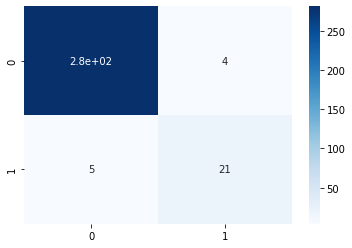

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = optimal_mlp.predict(X_test)
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap="Blues")

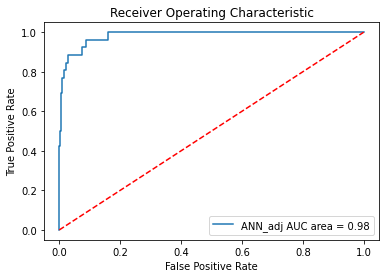

In [ ]:
models = [{"label": "ANN_adj", "model": optimal_mlp}]
# Plot roc curve
plot_roc_curves_for_models(models, X_test, y_test);

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       285
           1       0.84      0.81      0.82        26

    accuracy                           0.97       311
   macro avg       0.91      0.90      0.90       311
weighted avg       0.97      0.97      0.97       311



In [ ]:
test_y_pred = optimal_mlp.predict(X_test)
f1_score(y_test, test_y_pred, average='micro')

0.9710610932475884

In [ ]:
balanced_accuracy_score(y_test, test_y_pred)

0.8968286099865047

## GCN with MolGraphConvFeaturizer

In [ ]:
!pip install dgl
!pip install dgllife

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 2.9 MB/s 
     |████████████████████████████████| 1.9 MB 32.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 138 kB 3.3 MB/s 
     |████████████████████████████████| 1.6 MB 11.5 MB/s 
     |████████████████████████████████| 199 kB 27.9 MB/s 
     |████████████████████████████████| 829 kB 28.0 MB/s 
  Created wheel for dgllife: filename=dgllife-0.2.9-py3-none-any.whl size=219059 sha256=f9e04633854401347cf7a5090d64e9519c8d50a32288305caae884bc9c193fe5
  Stored in directory: /root/.cache/pip/wheels/34/83/11/9772c74b559d9182c9083362e8ba8b0201c4963e41e03859fe
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=4811110602782248454155f86094ebaf06a92c82fd32801980ce405efb539867
  Stored in directory: /root/.cache/pip/whee

In [ ]:
 model = dc.models.GCNModel(n_tasks=1)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
task = ['active']
featurizer_func = dc.feat.MolGraphConvFeaturizer()

loader = dc.data.CSVLoader(tasks=task, feature_field='smiles', featurizer=featurizer_func)
dataset = loader.create_dataset('/content/final_data.csv')

In [ ]:
transformer = dc.trans.BalancingTransformer(dataset=dataset)
dataset = transformer.transform(dataset)

In [ ]:
splitter = dc.splits.RandomStratifiedSplitter()
dataset = splitter.train_test_split(dataset)

In [ ]:
train_dataset, test_dataset = dataset

In [ ]:
model.fit(train_dataset)

/usr/local/lib/python3.7/dist-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


0.15529875755310057

In [ ]:
metric = dc.metrics.Metric(dc.metrics.roc_auc_score)
metric_2 = dc.metrics.Metric(dc.metrics.balanced_accuracy_score)

In [ ]:
print(model.evaluate(test_dataset, [metric]))
print(model.evaluate(test_dataset, [metric_2]))

{'roc_auc_score': 0.9456140350877194}
{'balanced_accuracy_score': 0.9193657219973009}


In [ ]:
test_y_pred = model.predict(test_dataset)
test_pred_binary = np.where(test_y_pred > 0.5, 1, 0)
metrics.f1_score(test_dataset.y, test_pred_binary, average='micro')

0.8842443729903537

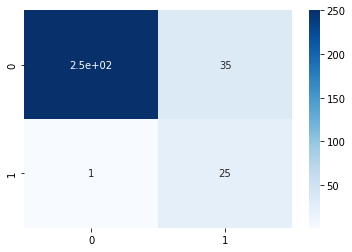

In [ ]:
sns.heatmap(confusion_matrix(test_dataset.y, test_pred_binary), annot=True, cmap="Blues")